In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install ultralytics
!pip install roboflow


In [2]:
from roboflow import Roboflow

# StoreAPI key in a variable 
robo_key = "iNqY8TjGSKAmKupTyEIE"

# Initialize Roboflow
rf = Roboflow(api_key=robo_key)

# Access the workspace
project = rf.workspace("sayed-gamall").project("fire-smoke-detection-yolov11")
version = project.version(2)

# Download the dataset in YOLOv11 format
dataset = version.download("yolov11")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Fire-Smoke-Detection-Yolov11-2 in yolov11:: 100%|██████████| 20938/20938 [00:02<00:00, 8299.77it/s] 


In [3]:
import os
import shutil

DATASET_PATH = "/kaggle/working/Fire-Smoke-Detection-Yolov11-2"

# OUTPUT PATH
OUTPUT_PATH = "classification_data"

CLASSES = {0: "Fire", 1: "Smoke"}

splits = ["train", "valid", "test"]

for split in splits:
    print(f"Processing {split}...")

    images_path = os.path.join(DATASET_PATH, split, "images")
    labels_path = os.path.join(DATASET_PATH, split, "labels")

    # Create output folders
    for cls in ["Fire", "Smoke", "Normal"]:
        os.makedirs(os.path.join(OUTPUT_PATH, split, cls), exist_ok=True)

    for img_name in os.listdir(images_path):
        if not img_name.lower().endswith((".jpg", ".png", ".jpeg")):
            continue

        base = os.path.splitext(img_name)[0]
        label_file = os.path.join(labels_path, base + ".txt")
        img_file = os.path.join(images_path, img_name)

        # Default class = NORMAL
        class_name = "Normal"

        # If label file exists and is not empty
        if os.path.exists(label_file):
            with open(label_file, "r") as f:
                lines = f.readlines()
                if len(lines) > 0:
                    first_class = int(lines[0].split()[0])
                    class_name = CLASSES.get(first_class, "Normal")

        # Copy image to class folder
        dest_folder = os.path.join(OUTPUT_PATH, split, class_name)
        shutil.copy(img_file, dest_folder)

print("Conversion Completed Successfully!")


Processing train...
Processing valid...
Processing test...
Conversion Completed Successfully!


In [4]:
import os

for split in ['train','valid','test']:
    root = f'/kaggle/working/classification_data/{split}'
    print("\n>>>", split.upper())
    print(os.listdir(root))



>>> TRAIN
['Fire', 'Smoke', 'Normal']

>>> VALID
['Fire', 'Smoke', 'Normal']

>>> TEST
['Fire', 'Smoke', 'Normal']


In [5]:
import os

normal_path = "/kaggle/working/classification_data/train/Normal"
print("Exists?", os.path.exists(normal_path))
print("Files:", os.listdir(normal_path)[:10])


Exists? True
Files: ['Img_1681_jpg.rf.5da52b757aed28fc303425b6e770301d.jpg', 'Datacluster-Fire-and-Smoke-Sample-40-_jpg.rf.1743724c400b13ecf46cd82d1ed823d4.jpg', 'Img_1102_jpg.rf.068b7bdcc543d06ddb80adba2d8912cb.jpg', 'Img_1101_jpg.rf.877833c95f35be951afee9bb096a0315.jpg']


In [6]:
import os

for split in ['train','valid','test']:
    normal_path = f"/kaggle/working/classification_data/{split}/Normal"
    print(f"\nChecking {split}/Normal:")
    print("Exists:", os.path.exists(normal_path))
    print("File count:", len(os.listdir(normal_path)) if os.path.exists(normal_path) else 0)



Checking train/Normal:
Exists: True
File count: 4

Checking valid/Normal:
Exists: True
File count: 0

Checking test/Normal:
Exists: True
File count: 0


In [9]:
import os
import shutil
import random

# Paths 
DATASET_PATH = "/kaggle/working/Fire-Smoke-Detection-Yolov11-2"
CLASS_DATA_PATH = "/kaggle/working/classification_data"

splits = ['train', 'valid', 'test']

TOTAL_NORMAL_PER_SPLIT = {
    'train': 80,
    'valid': 20,
    'test': 20
}

for split in splits:
    print(f"\nProcessing missing normals in {split}...")

    images_path = os.path.join(DATASET_PATH, split, "images")
    labels_path = os.path.join(DATASET_PATH, split, "labels")
    normal_dest = os.path.join(CLASS_DATA_PATH, split, "Normal")
    os.makedirs(normal_dest, exist_ok=True)

    # Find images WITHOUT labels
    unlabeled = []
    for img in os.listdir(images_path):
        if img.lower().endswith((".jpg", ".png", ".jpeg")):
            img_base = os.path.splitext(img)[0]
            label_file = os.path.join(labels_path, img_base + ".txt")
            if not os.path.exists(label_file):
                unlabeled.append(img)

    print(f"Found {len(unlabeled)} possible Normal images")

    # Randomly selecting required number
    needed = TOTAL_NORMAL_PER_SPLIT[split]
    selected = unlabeled[:needed] if len(unlabeled) >= needed else unlabeled

    for img_name in selected:
        src_img = os.path.join(images_path, img_name)
        shutil.copy(src_img, normal_dest)

    print(f"Added: {len(selected)} -> Normal folder")

print("\nDone! Normal class is now expanded properly.")



Processing missing normals in train...
Found 0 possible Normal images
Added: 0 -> Normal folder

Processing missing normals in valid...
Found 0 possible Normal images
Added: 0 -> Normal folder

Processing missing normals in test...
Found 0 possible Normal images
Added: 0 -> Normal folder

Done! Normal class is now expanded properly.


In [10]:
import os, shutil, random

RAW_NORMAL_PATH = "/kaggle/input/normal-images"
CLASS_DATA_PATH = "/kaggle/working/classification_data"

#  target folders 
for split in ['train','valid','test']:
    os.makedirs(os.path.join(CLASS_DATA_PATH, split, "Normal"), exist_ok=True)

# Collecting all Normal images uploaded
files = [f for f in os.listdir(RAW_NORMAL_PATH) if f.lower().endswith(('.jpg','.png','.jpeg'))]
random.shuffle(files)

# Split them 
train_split = int(len(files) * 0.8)   # 80% train
valid_split = int(len(files) * 0.1)   # 10% valid
test_split  = len(files) - train_split - valid_split # 10% test

train_files = files[:train_split]
valid_files = files[train_split:train_split + valid_split]
test_files  = files[train_split + valid_split:]

# Helper function for copying
def add_files(file_list, split):
    for file in file_list:
        src = os.path.join(RAW_NORMAL_PATH, file)
        dst = os.path.join(CLASS_DATA_PATH, split, "Normal", file)
        shutil.copy(src, dst)

# Copy files to target
add_files(train_files, "train")
add_files(valid_files, "valid")
add_files(test_files, "test")

print("Normal images added successfully!")
print(f"Train: {len(train_files)}, Valid: {len(valid_files)}, Test: {len(test_files)}")


Normal images added successfully!
Train: 40, Valid: 5, Test: 5


In [11]:
import os

for split in ['train','valid','test']:
    normal_path = f"/kaggle/working/classification_data/{split}/Normal"
    print(f"\nChecking {split}/Normal:")
    print("Exists:", os.path.exists(normal_path))
    print("File count:", len(os.listdir(normal_path)) if os.path.exists(normal_path) else 0)



Checking train/Normal:
Exists: True
File count: 44

Checking valid/Normal:
Exists: True
File count: 5

Checking test/Normal:
Exists: True
File count: 5


In [12]:
!pip install numpy==1.23.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 109.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
mkl-umath 0.1.1 requires numpy<1.27.0,>=1.26.4, but you have numpy 1.23.5 which is incompatible.
mkl-random 1.2.4 requires numpy<1.27.0,>=1.26.4, but you have numpy 1.23.5 which is incompatible.
mkl-fft 1.3.8 requires numpy<1.27.0,>=1.26.4, but you have numpy 1.23.5 which is incompatible.
datasets 4.4.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.1 which is incompatible.
woodwork 0.31.0 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
mne 1.10.2 requires 

In [13]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.models import ResNet18_Weights, VGG16_Weights, MobileNet_V2_Weights, EfficientNet_B0_Weights
from PIL import Image

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DATA_DIR = '/kaggle/working/classification_data'
BATCH_SIZE = 16
NUM_EPOCHS = 6
IMG_SIZE = 224
NUM_WORKERS = 0 
PIN_MEMORY = False

print("Device:", DEVICE)

# FORCE RGB CONVERSION 
def to_rgb(img):
    return img.convert("RGB")

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.Lambda(to_rgb),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(0.2,0.2,0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'valid': transforms.Compose([
        transforms.Lambda(to_rgb),
        transforms.Resize(int(IMG_SIZE*1.14)),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Lambda(to_rgb),
        transforms.Resize(int(IMG_SIZE*1.14)),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

#  DATASET LOAD
image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x), transform=data_transforms[x])
                  for x in ['train','valid','test']}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                             shuffle=(x=='train'), num_workers=NUM_WORKERS,
                             pin_memory=PIN_MEMORY)
               for x in ['train','valid','test']}

dataset_sizes = {x: len(image_datasets[x]) for x in image_datasets}
class_names = image_datasets['train'].classes
num_classes = len(class_names)

print("Classes:", class_names)
print("Dataset sizes:", dataset_sizes)

#  MODEL DEFINITIONS
def get_resnet18():
    model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(DEVICE)

def get_vgg16():
    model = models.vgg16(weights=VGG16_Weights.DEFAULT)
    model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)
    return model.to(DEVICE)

def get_mobilenet_v2():
    model = models.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
    model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)
    return model.to(DEVICE)

def get_efficientnet_b0():
    model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
    model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)
    return model.to(DEVICE)

models_to_train = {
    "ResNet18": get_resnet18,
    "VGG16": get_vgg16,
    "MobileNetV2": get_mobilenet_v2,
    "EfficientNetB0": get_efficientnet_b0
}

#  TRAIN + VALID FUNCTION
def train_and_eval(model, name):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

    best_acc = 0.0
    best_wts = None

    print(f"\n===== Training {name} =====")
    for epoch in range(NUM_EPOCHS):
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
        for phase in ['train','valid']:
            model.train() if phase=='train' else model.eval()
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase=='train':
                        loss.backward()
                        optimizer.step()

                running_corrects += torch.sum(preds == labels).item()

            if phase=='train':
                scheduler.step()

            epoch_acc = running_corrects / dataset_sizes[phase]
            print(f"{phase} Acc: {epoch_acc:.4f}")

            if phase=='valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_wts = model.state_dict()

    model.load_state_dict(best_wts)
    return model, best_acc

#  RUN ALL MODELS 
results = {}

for name, create_model in models_to_train.items():
    model = create_model()
    best_model, val_acc = train_and_eval(model, name)

    # TEST EVALUATION
    correct = 0
    best_model.eval()
    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            _, preds = torch.max(best_model(inputs), 1)
            correct += torch.sum(preds == labels).item()

    test_acc = correct / dataset_sizes['test']
    results[name] = (val_acc, test_acc)

#SHOW RESULTS 
print("\n=== FINAL RESULTS ===")
for model_name, (v_acc, t_acc) in results.items():
    print(f"{model_name} → Val: {v_acc:.4f} | Test: {t_acc:.4f}")

best_model = max(results, key=lambda x: results[x][0])
print(f"\n BEST MODEL: {best_model} with Val Accuracy: {results[best_model][0]:.4f}")


Device: cuda
Classes: ['Fire', 'Normal', 'Smoke']
Dataset sizes: {'train': 9196, 'valid': 877, 'test': 440}


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 222MB/s]



===== Training ResNet18 =====
Epoch 1/6
train Acc: 0.8521
valid Acc: 0.9168
Epoch 2/6
train Acc: 0.8846
valid Acc: 0.9259
Epoch 3/6
train Acc: 0.8892
valid Acc: 0.9247
Epoch 4/6
train Acc: 0.8953
valid Acc: 0.9054
Epoch 5/6
train Acc: 0.9079
valid Acc: 0.9316
Epoch 6/6
train Acc: 0.9153
valid Acc: 0.9327


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 252MB/s] 



===== Training VGG16 =====
Epoch 1/6
train Acc: 0.8324
valid Acc: 0.9019
Epoch 2/6
train Acc: 0.8657
valid Acc: 0.9179
Epoch 3/6
train Acc: 0.8752
valid Acc: 0.9156
Epoch 4/6
train Acc: 0.8795
valid Acc: 0.9225
Epoch 5/6
train Acc: 0.8951
valid Acc: 0.9225
Epoch 6/6
train Acc: 0.9044
valid Acc: 0.9236


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 206MB/s]



===== Training MobileNetV2 =====
Epoch 1/6
train Acc: 0.8512
valid Acc: 0.9304
Epoch 2/6
train Acc: 0.8884
valid Acc: 0.9247
Epoch 3/6
train Acc: 0.8998
valid Acc: 0.9339
Epoch 4/6
train Acc: 0.9064
valid Acc: 0.9327
Epoch 5/6
train Acc: 0.9103
valid Acc: 0.9316
Epoch 6/6
train Acc: 0.9161
valid Acc: 0.9339


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 208MB/s]



===== Training EfficientNetB0 =====
Epoch 1/6
train Acc: 0.8630
valid Acc: 0.9225
Epoch 2/6
train Acc: 0.9009
valid Acc: 0.9270
Epoch 3/6
train Acc: 0.9083
valid Acc: 0.9236
Epoch 4/6
train Acc: 0.9143
valid Acc: 0.9213
Epoch 5/6
train Acc: 0.9222
valid Acc: 0.9293
Epoch 6/6
train Acc: 0.9300
valid Acc: 0.9270

=== FINAL RESULTS ===
ResNet18 → Val: 0.9327 | Test: 0.9432
VGG16 → Val: 0.9236 | Test: 0.9273
MobileNetV2 → Val: 0.9339 | Test: 0.9500
EfficientNetB0 → Val: 0.9293 | Test: 0.9318

🔥 BEST MODEL: MobileNetV2 with Val Accuracy: 0.9339


In [14]:
# reuse: get_mobilenet_v2, train_and_eval, dataloaders, dataset_sizes, DEVICE, class_names

# Train ONLY the best model 
mobilenet_model = get_mobilenet_v2()
mobilenet_model, mb_val_acc = train_and_eval(mobilenet_model, "MobileNetV2_final")

print("Final MobileNetV2 val acc:", mb_val_acc)



===== Training MobileNetV2_final =====
Epoch 1/6
train Acc: 0.8530
valid Acc: 0.9236
Epoch 2/6
train Acc: 0.8839
valid Acc: 0.9270
Epoch 3/6
train Acc: 0.8943
valid Acc: 0.9384
Epoch 4/6
train Acc: 0.9052
valid Acc: 0.9316
Epoch 5/6
train Acc: 0.9142
valid Acc: 0.9339
Epoch 6/6
train Acc: 0.9175
valid Acc: 0.9396
Final MobileNetV2 val acc: 0.9395667046750285


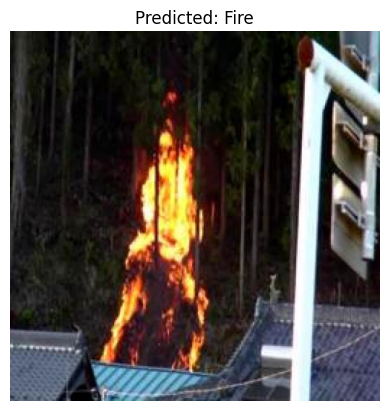

File: /kaggle/working/classification_data/test/Fire/Img_2046_jpg.rf.2fedc3f01890efefd47b248f9650f09e.jpg → Predicted: Fire


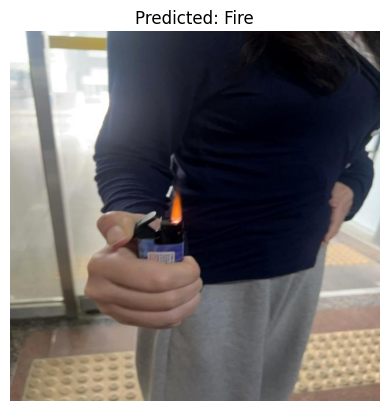

File: /kaggle/working/classification_data/test/Fire/IMG_3817-1-_jpeg_jpg.rf.fd7c87bd85a645e5625ec3216b36f9ca.jpg → Predicted: Fire


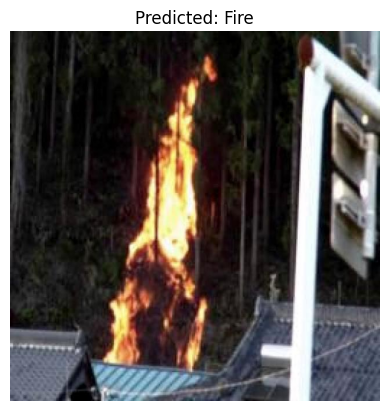

File: /kaggle/working/classification_data/test/Fire/Img_2030_jpg.rf.b8793305d916c6b03c6930aa87ddba58.jpg → Predicted: Fire


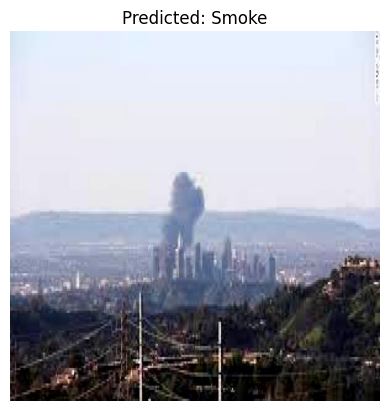

File: /kaggle/working/classification_data/test/Smoke/image_50_jpg.rf.a682518ba022b35f23f45121c29e53dd.jpg → Predicted: Smoke


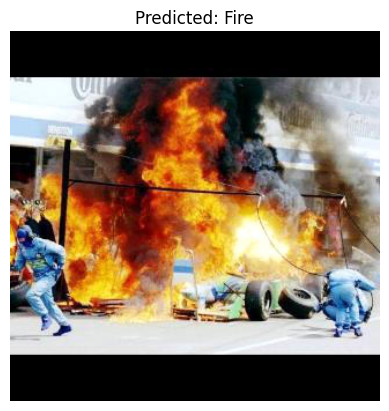

File: /kaggle/working/classification_data/test/Fire/WEBFire1371_jpg.rf.febfe9c09864860c5248e4eccc62ae5a.jpg → Predicted: Fire


In [15]:
import random
from PIL import Image
import matplotlib.pyplot as plt

test_transform = data_transforms['test']  

def predict_and_show_random(n=5):
    test_root = os.path.join(DATA_DIR, "test")
    # collect all image paths
    all_paths = []
    for cls in class_names:
        cls_dir = os.path.join(test_root, cls)
        for f in os.listdir(cls_dir):
            if f.lower().endswith(('.jpg', '.png', '.jpeg')):
                all_paths.append(os.path.join(cls_dir, f))

    sample_paths = random.sample(all_paths, n)

    mobilenet_model.eval()
    for path in sample_paths:
        img = Image.open(path).convert("RGB")
        inp = test_transform(img).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            out = mobilenet_model(inp)
            _, pred = torch.max(out, 1)
        label = class_names[pred.item()]

        plt.figure()
        plt.imshow(img)
        plt.title(f"Predicted: {label}")
        plt.axis("off")
        plt.show()
        print("File:", path, "→ Predicted:", label)

predict_and_show_random(5)


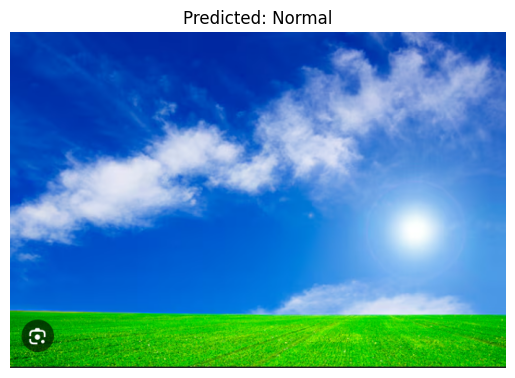

Predicted class: Normal


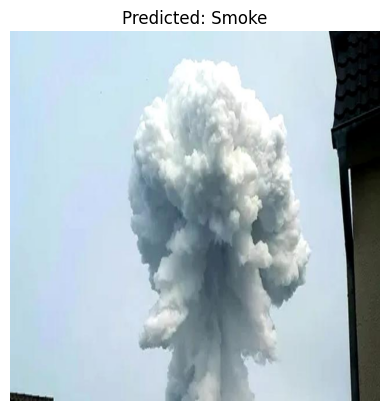

Predicted class: Smoke


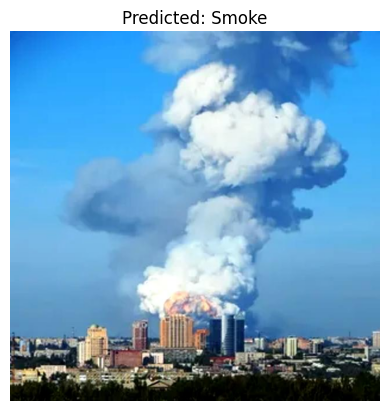

Predicted class: Smoke


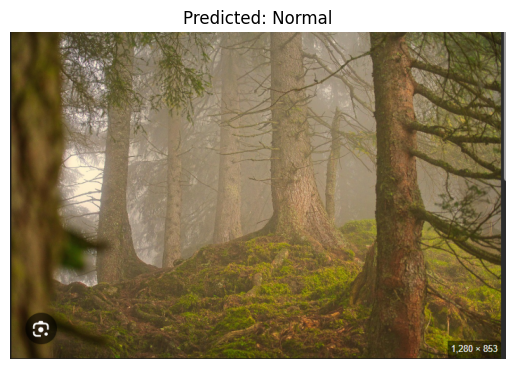

Predicted class: Normal


In [18]:
def predict_single_image(img_path):
    img = Image.open(img_path).convert("RGB")
    inp = test_transform(img).unsqueeze(0).to(DEVICE)
    mobilenet_model.eval()
    with torch.no_grad():
        out = mobilenet_model(inp)
        _, pred = torch.max(out, 1)
    label = class_names[pred.item()]

    plt.imshow(img)
    plt.title(f"Predicted: {label}")
    plt.axis("off")
    plt.show()
    print("Predicted class:", label)

# change path to your image
predict_single_image("/kaggle/working/classification_data/test/Normal/Screenshot 2025-12-01 165627.png")
predict_single_image("/kaggle/working/classification_data/test/Smoke/-539337_png.rf.35771d876c2a102ec6c75e999c9cdcfd.jpg")
predict_single_image("/kaggle/working/classification_data/test/Smoke/-E997446_png.rf.1781a22ff74cf7e91e420e9780a825fa.jpg")
predict_single_image("/kaggle/working/classification_data/valid/Normal/Screenshot 2025-12-01 165841.png")
